In [38]:
from google.colab import drive
drive.mount('/mnt/drive')

Drive already mounted at /mnt/drive; to attempt to forcibly remount, call drive.mount("/mnt/drive", force_remount=True).


In [0]:
!pip install tensorview

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import activations, datasets, layers, losses, metrics, models, optimizers, regularizers, Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, AveragePooling2D
import seaborn as sns
import pandas as pd
import tensorview as tv
import sklearn.metrics as skMetrics
from skimage import io, transform
from pathlib import Path
import tensorflow as tf

In [0]:
data_root = Path('/mnt/drive/My Drive/Colab Notebooks/mdi341-deeplearning/DeepLearning_Source_TF2/')
#data_root = Path('../../../DeepLearning_Source_TF2')
img_root = data_root / 'Databases/'

experiment_size = 100


## Steps

1. Network (test DB), perf > 85%
2. Test on image 48x48
3. Production script (load model, load image, estimate)
4. Adversarial image using gradient
5. Test modified image
6. L2 constraint

## Helpers

In [0]:
class DataSet(object):
    def __init__(self, path, filename_data, filename_gender, nbdata, batch_size=128):
        self.path = path
        self.filename_data = filename_data
        self.filename_gender = filename_gender
        self.nbdata = nbdata
        self.name = filename_data
        # taille des images 48*48 pixels en niveau de gris
        self.width = self.height = 48
        self.channels = 1
        self.dim = self.width * self.height * self.channels
        self.data = None
        self.label = None
        self.batch_size = batch_size

    def load(self):
        f = open(self.path.joinpath(self.filename_data), 'rb')
        self.data = np.empty(self.shape(True), dtype=np.float32)
        for i in range(self.nbdata):
            self.data[i, :] = np.fromfile(f, dtype=np.uint8, count=self.dim) \
                .reshape(self.shape())
        f.close()

        f = open(self.path.joinpath(self.filename_gender), 'rb')
        self.label = np.empty([self.nbdata, 2], dtype=np.float32)
        for i in range(self.nbdata):
            self.label[i, :] = np.fromfile(f, dtype=np.float32, count=2)
        f.close()

        self.data = (self.data - 128.0) / 256.0

        tmpdata = np.empty([1, self.dim], dtype=np.float32)
        tmplabel = np.empty([1, 2], dtype=np.float32)
        arr = np.arange(self.nbdata)
        np.random.shuffle(arr)
        tmpdata = self.data[arr[0], :]
        tmplabel = self.label[arr[0], :]
        for i in range(self.nbdata - 1):
            self.data[arr[i], :] = self.data[arr[i + 1], :]
            self.label[arr[i], :] = self.label[arr[i + 1], :]
        self.data[arr[self.nbdata - 1], :] = tmpdata
        self.label[arr[self.nbdata - 1], :] = tmplabel

    def shape(self, batch=False):
        if batch:
            return (self.nbdata, self.width, self.height, self.channels)
        else:
            return (self.width, self.height, self.channels)

In [0]:
def plotHeatMap(X, classes='auto', title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None,
               vmin=None, vmax=None, cbar=True):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, 
                     fmt=fmt, vmin=vmin, vmax=vmax, cbar=cbar, cmap=plt.cm.bwr, ax=ax) 
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotHistory(hist, with_validation=False, sharey=False):
    """ Plot a classification history as outputted by Keras """
    metrics = list(filter(lambda s: not s.startswith('val_'), hist.history.keys()))
    fig, axes = plt.subplots(1, len(metrics), figsize=(15,6), sharey=sharey)
    for m, ax in zip(metrics, axes):
        ax.plot(hist.history[m])
        if with_validation:
            ax.plot(hist.history['val_'  + m])
            ax.legend(('train', 'valid'))
        ax.set_title(m)
        ax.set_xlabel('epoch')
        ax.grid()
        
def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    """ Compute and plot the confusion matrix """
    plotHeatMap(skMetrics.confusion_matrix(yTrue, yEst), classes, title, fmt, ax, \
                xlabel='Estimations', ylabel='True values');
    
def plotFaces(nrows, ncols, ds, estimates=None):
    ntotal = nrows * ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 5*nrows))
    if estimates is None:
        for img, gender, ax in zip(ds.data[:ntotal], ds.label, axes.ravel()):
            ax.imshow(img.squeeze(), cmap='gray')
            ax.set_title(genders[np.argmax(gender, axis=0)])
    else:
        for img, gender, est, ax in zip(ds.data[:ntotal], ds.label, estimates, axes.ravel()):
            ax.imshow(img.squeeze(), cmap='gray')
            ax.set_title(genders[np.argmax(gender, axis=0)])
            e = np.argmax(est, axis=0)
            ax.set_xlabel("Pred %s (%.1f%%)" % (genders[e], est[e] * 100))

## Data

In [44]:
train = DataSet(path=img_root, filename_data=f'data_{experiment_size}k.bin',
                filename_gender=f'gender_{experiment_size}k.bin', nbdata=1000*experiment_size)
train.load()
test = DataSet(img_root, 'data_test10k.bin','gender_test10k.bin', 10000)
test.load()

genders = ['Male', 'Female']

train.nbdata, test.nbdata

(100000, 10000)

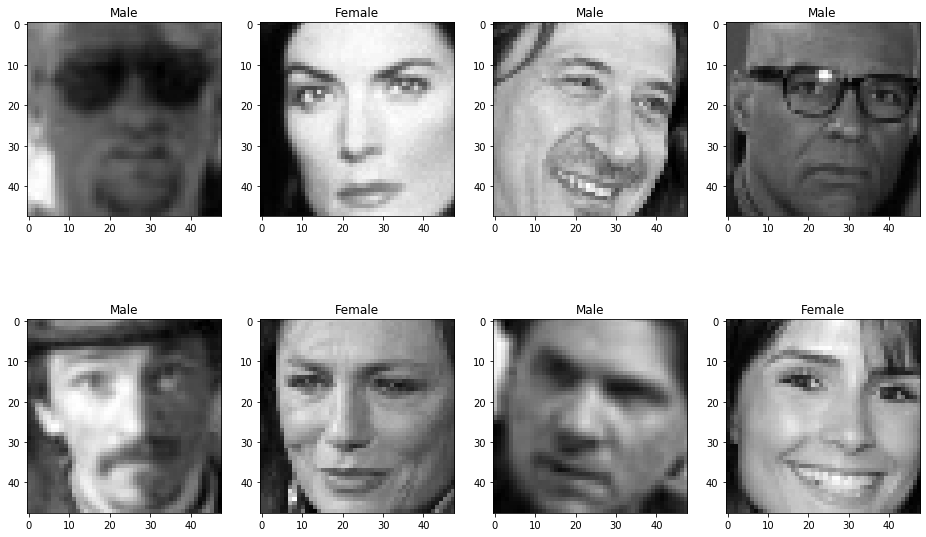

In [45]:
plotFaces(2, 4, train)

## Model

Based on provided nn4 model with a little more filters on each convolutional layer

In [46]:
model1 = models.Sequential([
    layers.Conv2D(filters=4, kernel_size=(3, 3), padding='same',
                  activation=activations.relu, 
                  input_shape=(train.width, train.height, train.channels), name='conv_1'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same',
                  activation=activations.relu, name='conv_2'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same',
                  activation=activations.relu, name='conv_3'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(2, activation=activations.sigmoid)
])

model1.compile(optimizer=optimizers.Adam(),
               loss=losses.binary_crossentropy,
               metrics=['accuracy'])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 48, 48, 4)         40        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 4)         0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 24, 8)         296       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 12, 12, 16)        1168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)              

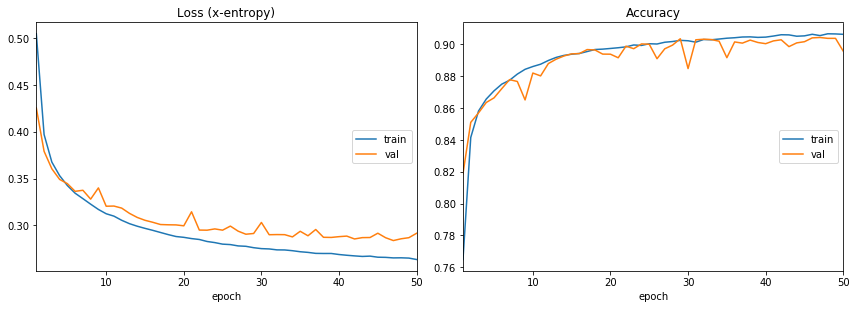

In [47]:
n_epochs = 50
metric_names = ['Loss (x-entropy)', 'Accuracy']
tv_plot = tv.train.PlotMetricsOnEpoch(metrics_name=metric_names,
                cell_size=(6,4), columns=2, iter_num=n_epochs, wait_num=1)
history1 = model1.fit(train.data, train.label,
                epochs=n_epochs, batch_size=train.batch_size, 
                validation_split=0.1, 
                verbose=0,
                callbacks=[tv_plot]);

Overfitting is observed : The validation loss and accuracy are plateauing while training is improving, and they are irregular (bumpy) compared to the training

In [0]:
#plotHistory(history1, True, False)

### 1.1 Test

In [0]:
y_est1 = model1.predict(test.data)

In [50]:
score1 = np.mean(np.argmax(test.label, axis=1) == np.argmax(y_est1, axis=1))
print("Accuracy : %.1f %%" % (score1*100))

Accuracy : 88.5 %


Overfitting is confirmed, test accuracy is lower than the final validation accuracy.

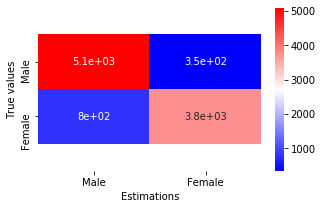

In [51]:
fig, ax = plt.subplots(figsize=(5, 3))
plotConfusionMatrix(np.argmax(test.label, axis=1), np.argmax(y_est1, axis=1), genders)

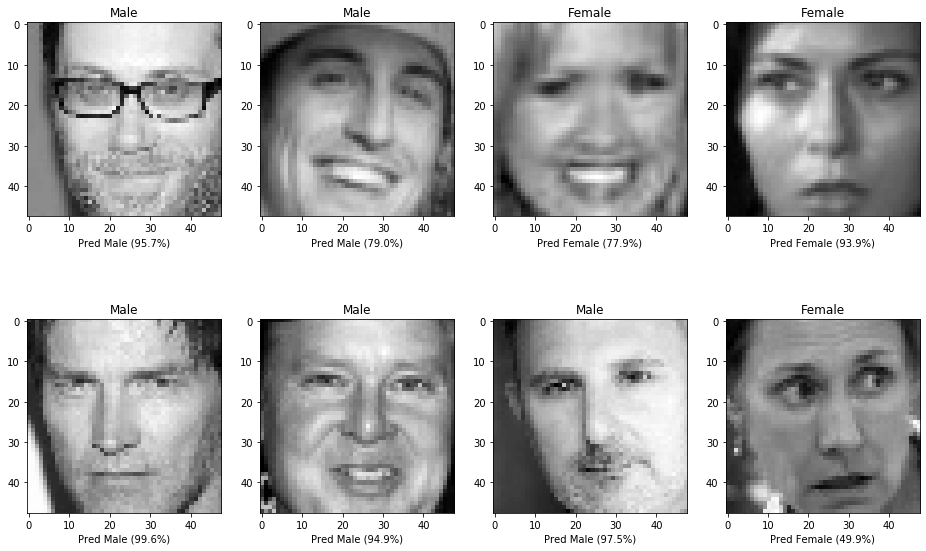

In [52]:
plotFaces(2, 4, test, y_est1)

### 1.2 Save model

In [0]:
model1.save(data_root / ('model1-%.3f.h5' % score1))

## 2. More complex architecture

Based on GoogLeNet Inception layer

In [0]:
n, h, w, c = train.data.shape

In [55]:
input_img = Input(shape=(h, w, 1))

def inception_l1s1(input_img):
    x = Conv2D(4, (1,1), padding='same', activation=activations.relu, name='l1s1_1')(input_img)
    x = Conv2D(6, (3,3), padding='same', activation=activations.relu, name='l1s1_2')(x)
    x = Conv2D(12, (1,1), padding='same', activation=activations.relu, name='l1s1_3')(x)
    x = AveragePooling2D((3, 3), strides=(1,1), padding='same', name='l1_4')(x)
    return x

def inception_l1s2(input_img):
    x = Conv2D(4, (6, 6), padding='same', activation=activations.relu, name='l1s2_1')(input_img)
    x = Conv2D(6, (2, 2), padding='same', activation=activations.relu, name='l1s2_2')(x)
    x = Conv2D(12, (1, 1), padding='same', activation=activations.relu, name='l1s2_3')(x)
    x = MaxPooling2D((3,3), strides=(1,1), padding='same', name='l1s2_4')(x)
    return x

inception_1 = tf.keras.layers.concatenate([inception_l1s1(input_img), inception_l1s2(input_img)], 
                                          axis = 3, name='l1_concat')
x = Dense(5, activation=activations.relu)(inception_1)

x = Conv2D(6, (3,3), padding='same', activation=activations.relu, name='l2_1')(x)
x = MaxPooling2D((3,3), strides=(1,1), padding='same', name='l2_2')(x)
inception_2 = tf.keras.layers.concatenate([x, input_img], axis=3, name='l2_concat')

x = Conv2D(12, (2,2), padding='same', activation=activations.relu, name='l3_1')(inception_2)
x = Conv2D(16, (4,4), padding='same', activation=activations.relu, name='l3_2')(x)
x = Conv2D(18, (1,1), padding='same', activation=activations.relu, name='l3_3')(x)
x = Dropout(0.5, name='l3_drop1')(x)
x = Dense(5, activation=activations.relu, name='l3_4')(x)
x = Flatten(name='l3_flat1')(x)
output = Dense(2, activation=activations.sigmoid, name='l3_5')(x)

model2 = Model([input_img], output)

model2.compile(optimizer=optimizers.Adam(),
               loss=losses.binary_crossentropy,
               metrics=['accuracy'])

model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
l1s1_1 (Conv2D)                 (None, 48, 48, 4)    8           input_3[0][0]                    
__________________________________________________________________________________________________
l1s2_1 (Conv2D)                 (None, 48, 48, 4)    148         input_3[0][0]                    
__________________________________________________________________________________________________
l1s1_2 (Conv2D)                 (None, 48, 48, 6)    222         l1s1_1[0][0]                     
____________________________________________________________________________________________

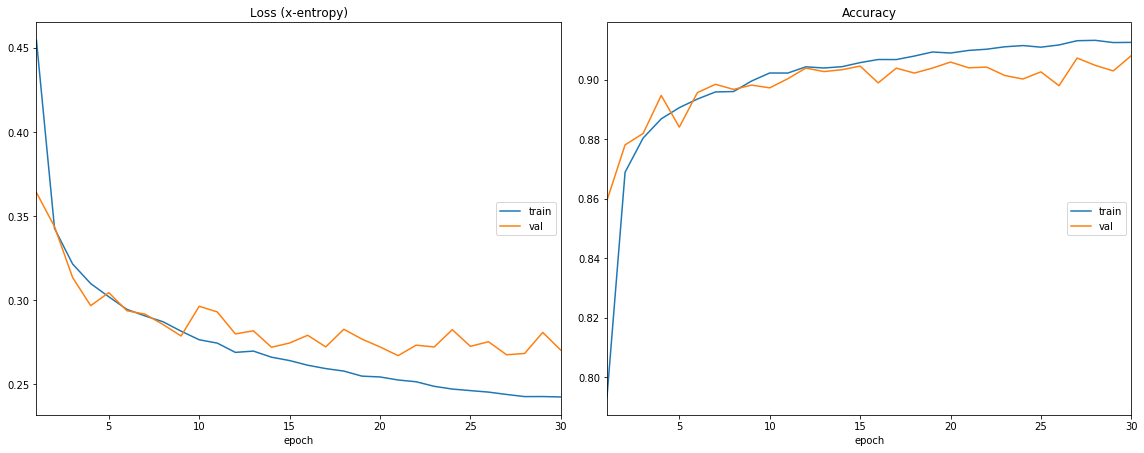

In [56]:
n_epochs = 30
metric_names = ['Loss (x-entropy)', 'Accuracy']
tv_plot = tv.train.PlotMetricsOnEpoch(metrics_name=metric_names,
                cell_size=(8,6), columns=2, iter_num=n_epochs, wait_num=1)
history2 = model2.fit(train.data, train.label,
                epochs=n_epochs, batch_size=train.batch_size, 
                validation_split=0.20, 
                verbose=0,
                callbacks=[tv_plot])

In [0]:
y_est2 = model2.predict(test.data)

In [58]:
score = np.mean(np.argmax(test.label, axis=1) == np.argmax(y_est2, axis=1))
print("Accuracy : %.1f %%" % (score*100))

Accuracy : 89.8 %


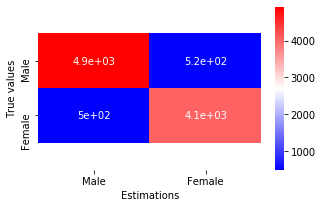

In [59]:
fig, ax = plt.subplots(figsize=(5, 3))
plotConfusionMatrix(np.argmax(test.label, axis=1), np.argmax(y_est2, axis=1), genders)

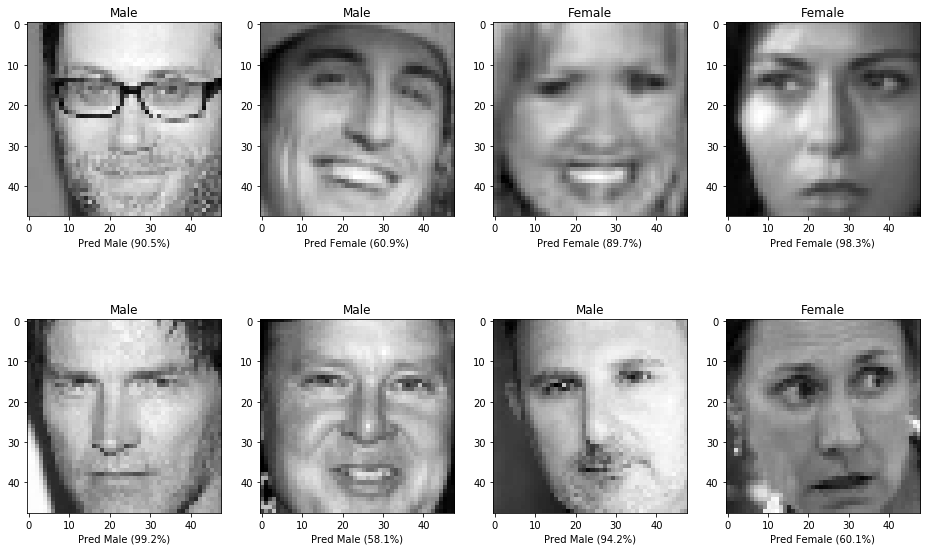

In [60]:
plotFaces(2, 4, test, y_est2)

### 2.2 Save model

In [0]:
model2.save(data_root / ('model2-%.3f.h5' % score))

## 3. Test on image from Internet

### 3.1 Quick resize

Resize without taking into account for aspect ratio, without focusing on the face

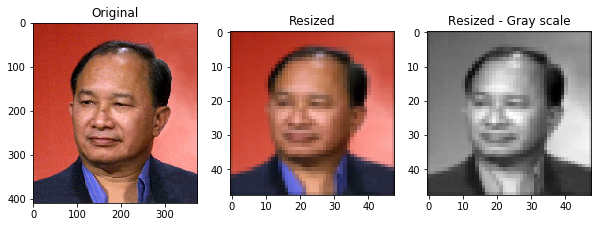

In [62]:
jw = io.imread('https://upload.wikimedia.org/wikipedia/commons/0/02/John_Woo_Cannes_2005.jpg')
jw1 = transform.resize(jw, (48, 48, 3), mode='constant').astype(np.float32)
jw1g = np.mean(jw1, axis=2)
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(jw);
axes[0].set_title('Original')
axes[1].imshow(jw1);
axes[1].set_title('Resized')
axes[2].imshow(jw1g, cmap='gray');
axes[2].set_title('Resized - Gray scale');

Prediction without focusing on the head

In [63]:
predJw1Soft = model2.predict(jw1g.reshape(1, test.width, test.height, 1))
predJw1 = np.argmax(predJw1Soft[0])
print("Prediction for John Woo (unfocused) : %s (%.1f%%)" % (genders[predJw1], predJw1Soft[0,predJw1]*100))

Prediction for John Woo (unfocused) : Female (85.6%)


### 3.2 Manual crop to focus on face

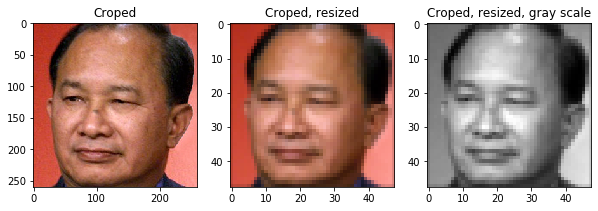

In [64]:
jw2   = jw[60:320, 60:320]
jw2r  = transform.resize(jw2, (48, 48, 3), mode='constant').astype(np.float32)
jw2g = np.mean(jw2r, axis=2)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(jw2);
axes[0].set_title('Croped')
axes[1].imshow(jw2r);
axes[1].set_title('Croped, resized')
axes[2].imshow(jw2g, cmap='gray');
axes[2].set_title('Croped, resized, gray scale');

In [65]:
predJw2Soft1 = model1.predict(jw2g.reshape(1, test.width, test.height, 1))
predJw2Hard1 = np.argmax(predJw2Soft1[0])
print("Prediction model 1 for John Woo (focused) : %s (%.1f%%)" % (genders[predJw2Hard1], predJw2Soft1[0, predJw2Hard1]*100))
predJw2Soft2 = model2.predict(jw2g.reshape(1, test.width, test.height, 1))
predJw2Hard2 = np.argmax(predJw2Soft2[0])
print("Prediction model 2 for John Woo (focused) : %s (%.1f%%)" % (genders[predJw2Hard2], predJw2Soft2[0, predJw2Hard2]*100))

Prediction model 1 for John Woo (focused) : Male (88.2%)
Prediction model 2 for John Woo (focused) : Female (65.2%)


## 4. Script to load and apply

## 5. Adversarial example

In [0]:
# Load the model
#model_path = data_root + Path('/model1-0.8929.h5')
#model1 = tf.keras.models.load_model(model_path)

In [0]:
def adversarial_pattern(model, image, true_label):
    image = tf.cast(image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.binary_crossentropy(true_label, prediction)
  
    gradient = tape.gradient(loss, image)  
    signed_grad = tf.sign(gradient)
  
    return signed_grad

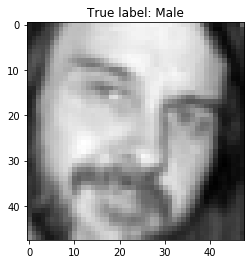

In [83]:
n = train.data.shape[0]
index = np.random.randint(0, n)
image = train.data[index, :,:,:]

# We compute a wrong label
label = train.label[index, :]
plt.imshow(image.reshape(48, 48), cmap='gray')
plt.title(f'True label: {genders[np.argmax(label)]}');

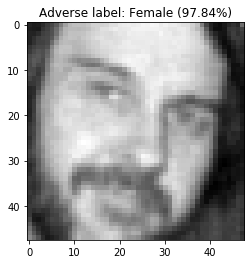

In [88]:
eps = 0.01

perturbations = adversarial_pattern(model2, image.reshape((1, 48, 48, 1)), label).numpy()
adversarial = image + perturbations * eps

plt.imshow(adversarial.reshape(48, 48), cmap='gray')

pred = model2.predict(adversarial.reshape((1, 48, 48, 1)))
adverse_label = np.argmax(pred)
plt.title(f'Adverse label: %s (%.2f%%)' % (genders[adverse_label], pred[0][adverse_label]*100));

False label: 1
Confidence: 0.14099232852458954


## 5. Regularization

In [0]:
model3 = models.Sequential([
    layers.Conv2D(filters=4, kernel_size=(3, 3), padding='same',
                  input_shape=(train.width, train.height, train.channels),
                  activation=activations.relu, name='conv_1'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same',
                  activation=activations.relu, name='conv_2'),
    layers.Dropout(0.2),
    layers.MaxPooling2D(),
        layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same',
                      activation=activations.relu, name='conv_3'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(2, activation=activations.sigmoid)
])

model3.compile(optimizer=optimizers.Adam(),
                   loss=losses.binary_crossentropy,
                   metrics=['accuracy'])

#model3.summary()

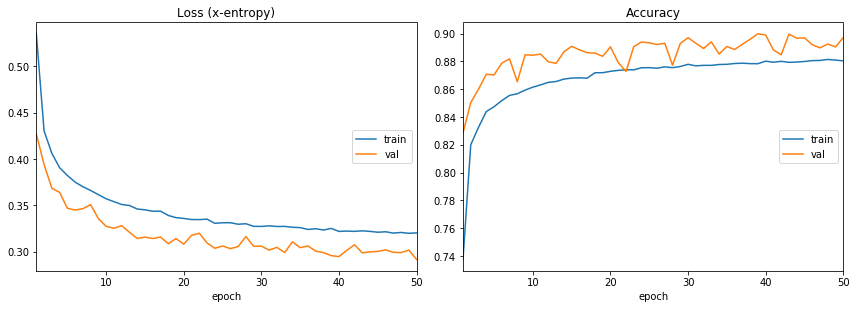

In [72]:
n_epochs = 50
metric_names = ['Loss (x-entropy)', 'Accuracy']
tv_plot = tv.train.PlotMetricsOnEpoch(metrics_name=metric_names,
                cell_size=(6,4), columns=2, iter_num=n_epochs, wait_num=1)
history3 = model3.fit(train.data, train.label,
                epochs=n_epochs, batch_size=train.batch_size, 
                validation_split=0.1, 
                verbose=0,
                callbacks=[tv_plot]);

With regularization (dropout) :
- The plateau of the validation loss @ 0.43 is gone, but there seems to be a plateau  @ 0.40
- Convergence is faster, the validation is well over 80% accuracy at epoch #10, was barely 80% previously
- The training performance is lower due to the dropout (not applied during validation)

### 5.1 Test

In [0]:
y_est3 = model3.predict(test.data)

In [89]:
score3 = np.mean(np.argmax(test.label, axis=1) == np.argmax(y_est3, axis=1))
print("Score : %.1f %%" % (score*100))

Score : 89.0 %


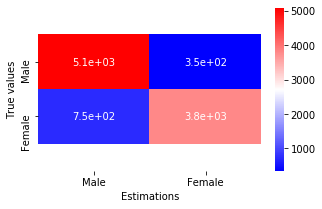

In [75]:
fig, ax = plt.subplots(figsize=(5, 3))
plotConfusionMatrix(np.argmax(test.label, axis=1), np.argmax(y_est3, axis=1), genders)

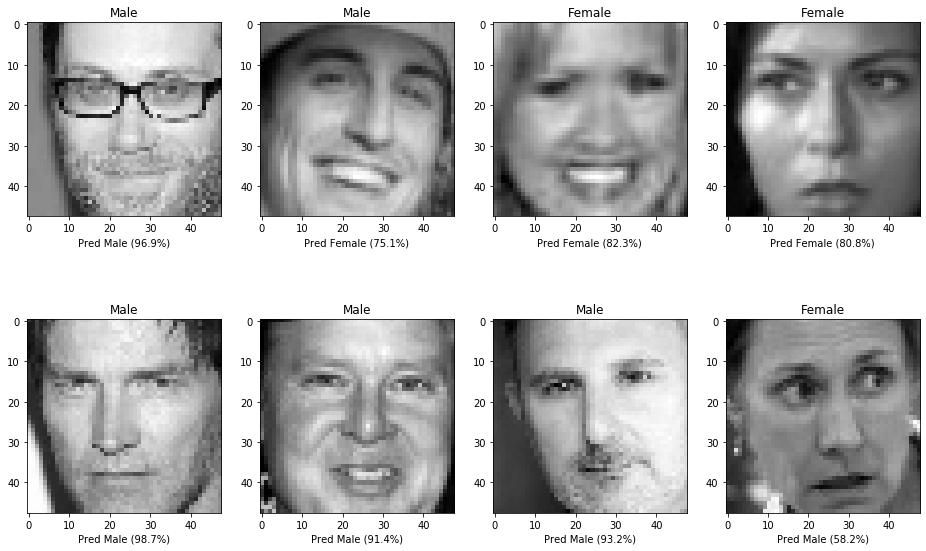

In [76]:
plotFaces(2, 4, test, y_est3)

In [77]:
predJw1Soft3 = model3.predict(jw1g.reshape(1, test.width, test.height, 1))
predJw13 = np.argmax(predJw1Soft3[0])
print("Prediction for John Woo (unfocused) : %s (%.1f%%)" % (genders[predJw13], predJw1Soft3[0, predJw13] * 100))

Prediction for John Woo (unfocused) : Female (55.8%)


In [78]:
predJw2Soft3 = model3.predict(jw2g.reshape(1, test.width, test.height, 1))
predJw23 = np.argmax(predJw2Soft2[0])
print("Prediction for John Woo (focused) : %s (%.1f%%)" % (genders[predJw23], predJw2Soft3[0, predJw23] * 100))

Prediction for John Woo (focused) : Female (24.5%)


### 5.2 Save model

In [0]:
model3.save(data_root / ('model3-%.3f.h5' % score))